# Laboratorium 4
## Marcin Ogórkiewicz
### 27.05.2025
#### Własne środowisko

Import potrzebnych bibliotek

In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import pandas as pd
from tabulate import tabulate

### Zadanie 1
Zaimplementować własne środowisko z wykorzystaniem API Gymnasium

In [7]:
class CustomEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(CustomEnv, self).__init__()
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32)

        self.state = None
        self.reset()

    def step(self, action):
        self.state = self._update_state(action)

        reward = self._calculate_reward()

        terminated = self._check_terminated()
        truncated = False

        info = {}

        return self.state, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        # Zresetuj stan środowiska do stanu początkowego
        self.state = np.random.uniform(low=-1, high=1, size=(4,))
        info = {}
        return self.state, info

    def _update_state(self, action):
        # Implementacja logiki przejścia stanu
        new_state = self.state.copy()
        if action == 0:
            new_state[0] += 0.1
        elif action == 1:
            new_state[0] -= 0.1
        else:
            new_state[1] += 0.1

        # Dodaj szum
        new_state += np.random.normal(0, 0.01, size=(4,))

        # Przytnij do granic przestrzeni obserwacji
        new_state = np.clip(new_state, self.observation_space.low, self.observation_space.high)

        return new_state

    def _calculate_reward(self):
        target = np.array([5.0, 5.0, 0.0, 0.0])
        distance = np.linalg.norm(self.state - target)
        reward = -distance  # Ujemna odległość jako nagroda

        # Bonus za osiągnięcie celu
        if distance < 0.5:
            reward += 10

        return reward

    def _check_terminated(self):
        target = np.array([5.0, 5.0, 0.0, 0.0])
        distance = np.linalg.norm(self.state - target)

        if distance < 0.5:  # Osiągnięto cel
            return True

        # Sprawdź, czy poza granicami
        if np.any(np.abs(self.state) > 9.5):
            return True

        return False

gym.envs.registration.register(
    id="CustomEnv-v0",
    entry_point="%s:CustomEnv" % __name__,
    max_episode_steps=100,
)

/home/marcin/PycharmProjects/arisc/.venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment CustomEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


### Zadanie 2
Wybrać oraz przeprowadzić trening modelu

In [8]:
# Utworzenie instancji środowiska
env = gym.make('CustomEnv-v0')

# Trening modelu
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000)

# Ewaluacja wytrenowanego modelu
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True)
print(f"Średnia nagroda: {mean_reward:.2f} +/- {std_reward:.2f}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -603     |
| time/              |          |
|    fps             | 750      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -614         |
| time/                   |              |
|    fps                  | 609          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0070372312 |
|    clip_fraction        | 0.0144       |
|    clip_range           | 0.2          |
|    e

### Zadanie 3
Wykonać test i zebrać wyniki działania modelu (uzyskana nagroda)

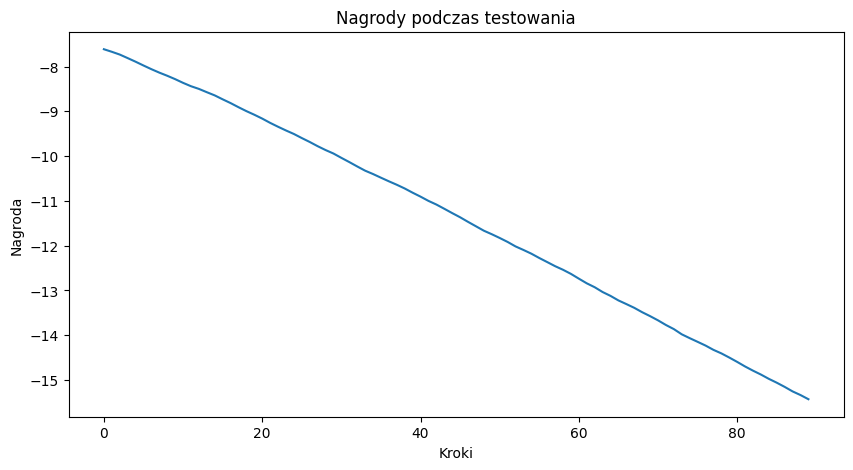

Epizod 1: Nagroda = -485.15, Kroki = 88
Epizod 2: Nagroda = -481.20, Kroki = 89
Epizod 3: Nagroda = -485.58, Kroki = 89
Epizod 4: Nagroda = -1085.42, Kroki = 97
Epizod 5: Nagroda = -569.15, Kroki = 88
Epizod 6: Nagroda = -461.57, Kroki = 88
Epizod 7: Nagroda = -593.26, Kroki = 95
Epizod 8: Nagroda = -637.05, Kroki = 100
Epizod 9: Nagroda = -586.09, Kroki = 99
Epizod 10: Nagroda = -658.21, Kroki = 100

Wyniki ewaluacji modelu:
+--------------+------------+-------------------+---------------+---------------+------------------------+-------------------------+---------------------+-----------------+
| Środowisko   | Algorytm   |   Średnia nagroda |   Min nagroda |   Max nagroda |   Odch. stand. nagrody |   Średnia liczba kroków |   Czas treningu (s) |   Kroki/sekunda |
+==============+============+===================+===============+===============+========================+=========================+=====================+=================+
| CustomEnv-v0 | PPO        |           -604.27 |  

In [9]:
# Test modelu
obs, _ = env.reset()
rewards = []
for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    if terminated or truncated:
        obs, _ = env.reset()
        break

# Wizualizacja wyników
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title('Nagrody podczas testowania')
plt.xlabel('Kroki')
plt.ylabel('Nagroda')
plt.show()


def evaluate_model(model, env_name, episodes=10):
    env = gym.make(env_name)
    rewards = []
    steps = []

    for episode in range(episodes):
        terminated = False
        truncated = False
        obs, _ = env.reset()
        total_reward = 0
        step_count = 0

        while not (terminated or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            step_count += 1

        rewards.append(total_reward)
        steps.append(step_count)
        print(f"Epizod {episode+1}: Nagroda = {total_reward:.2f}, Kroki = {step_count}")

    return rewards, steps

training_time = 60.5
total_timesteps = 50000

# Uruchomienie ewaluacji
rewards, steps = evaluate_model(model, "CustomEnv-v0")

results_data = {
    'Środowisko': ['CustomEnv-v0'],
    'Algorytm': ['PPO'],
    'Średnia nagroda': [f"{np.mean(rewards):.2f}"],
    'Min nagroda': [f"{np.min(rewards):.2f}"],
    'Max nagroda': [f"{np.max(rewards):.2f}"],
    'Odch. stand. nagrody': [f"{np.std(rewards):.2f}"],
    'Średnia liczba kroków': [f"{np.mean(steps):.2f}"],
    'Czas treningu (s)': [f"{training_time:.2f}"],
    'Kroki/sekunda': [f"{total_timesteps/training_time:.2f}"]
}

results_df = pd.DataFrame(results_data)
print("\nWyniki ewaluacji modelu:")
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False))

### Wnioski

W ramach laboratorium stworzyłem własne środowisko z wykorzystaniem API Gymnasium, implementując problem nawigacji agenta do określonego celu w przestrzeni 4D. Następnie wytrenowałem model PPO, który nauczył się poruszać w stronę celu. Ujemne wartości nagrody wynikają z zaprojektowanej funkcji nagrody opartej na odległości - im bliżej celu, tym mniejsza ujemna wartość.

Trening wykazał, że agent był w stanie nauczyć się strategii zbliżania do celu, choć nie zawsze go osiągał w ramach dostępnych kroków. Implementacja własnego środowiska pozwoliła na praktyczne zastosowanie koncepcji uczenia ze wzmocnieniem w kontrolowanym scenariuszu.

Szczególnie ciekawe było obserwowanie, jak agent adaptował swoją strategię do osiągnięcia celu mimo wprowadzonego szumu w aktualizacji stanu. Doświadczenie to dało mi praktyczny wgląd w mechanizmy projektowania środowisk i trenowania agentów w uczeniu ze wzmocnieniem.